In [182]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import collections
import string
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pickle

plt.style.use('fivethirtyeight')

%matplotlib inline
% config InlineBackend.figure_format = 'retina'

In [111]:
df = pd.read_csv('all_songs.csv')

In [112]:
def is_instrumental(cell):
    if 'instrumental' in cell.lower():
        return 1
    else:
        return 0

In [113]:
df['is_instrumental'] = df['lyrics'].apply(is_instrumental)

In [114]:
df['is_instrumental'].sum()

2541

In [115]:
df = df.loc[df['is_instrumental'] == 0]

In [119]:
all_music = df.drop_duplicates(subset=['album', 'artist', 'song'])

In [124]:
def need_space(cell):
    return cell + ' '

In [126]:
all_music['lyrics'] = all_music['lyrics'].apply(need_space)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [131]:
all_albums = all_music.groupby('album_id')[['lyrics']].sum()

all_albums = all_albums.reset_index()

In [135]:
labels_df = all_music.groupby('album_id')[[
                'is_folk',
                'is_folk_rock',
                'is_indie_folk',
                'is_alt_country',
                'is_alt_rock',
                'is_experimental_rock',
                'is_hip_hop',
                'is_pop_songs', 
                'is_rock_songs'
            ]].mean()

In [137]:
labels_df = labels_df.reset_index()

In [8]:
def lable_adjuster(cell):
    if cell != 0:
        return 1
    else:
        return 0

In [138]:
for col in ['is_folk', 'is_folk_rock', 'is_indie_folk', 'is_alt_country', 'is_alt_rock',
            'is_experimental_rock', 'is_hip_hop', 'is_pop_songs', 'is_rock_songs']:
    labels_df[col] = labels_df[col].apply(lable_adjuster)

In [140]:
albums_df = pd.merge(left=all_albums, right=labels_df, on='album_id')

In [12]:
def lyric_cleaner(songs):
    lyric_tokens = []
    for song in songs:
        text = song.lower().replace(' n ', ' eol ').replace('[verse ', '[verse')
        text = text.replace("'", '').replace('-', ' ')
        table = str.maketrans('', '', string.punctuation)
        text = text.translate(table)
        lyric_tokens.append(text)
    return lyric_tokens

In [142]:
albums = albums_df['lyrics']

tokens = lyric_cleaner(albums)

albums_df['tokens'] = tokens

In [146]:
albums_df[['is_folk', 'is_folk_rock', 'is_indie_folk', 'is_alt_country', 'is_alt_rock',
            'is_experimental_rock', 'is_hip_hop', 'is_pop_songs', 'is_rock_songs']].sum()

is_folk                  516
is_folk_rock             101
is_indie_folk            170
is_alt_country           124
is_alt_rock              457
is_experimental_rock      90
is_hip_hop               846
is_pop_songs             240
is_rock_songs           1472
dtype: int64

In [147]:
def main_label(row):
    if row['is_pop_songs']:
        return 'pop'
    
    elif row['is_folk']:
        return 'folk'
    
    elif row['is_hip_hop']:
        return 'hip_hop'
    
    elif row['is_rock_songs'] | row['is_alt_rock']:
        return 'rock'
    
    else:
        return 'folk'

In [148]:
def genre_colors(cell):
    
    if cell == 'pop':
        return 'xkcd:orangey yellow'
    
    elif cell == 'folk':
        return 'xkcd:indigo'
    
    elif cell == 'hip_hop':
        return 'xkcd:tomato'
    
    elif cell == 'rock':
        return 'xkcd:grey blue'
    
    else:
        return 'xkcd:vibrant green'

In [149]:
albums_df['primary_genre'] = albums_df.apply(main_label, axis=1)

albums_df['primary_color'] = albums_df['primary_genre'].apply(genre_colors)

In [152]:
albums_df['primary_genre'].value_counts()

rock       1929
hip_hop     846
folk        789
pop         240
Name: primary_genre, dtype: int64

In [158]:
stop = set(ENGLISH_STOP_WORDS)

list_of_stop_words_to_add = ['chourus, hook, verse, eos, eol, n', '1', '2', '3', '4']

for word in list_of_stop_words_to_add:
    stop.add(word)

In [168]:
cv = CountVectorizer(min_df=0.01, ngram_range=(1, 3), stop_words=['chourus, verse, eos, eol, n', '1', '2', '3', '4'])

tokens_v = cv.fit_transform(tokens)

array_tokens = tokens_v.toarray()

In [170]:
array_tokens.nbytes

1427534688

In [179]:
svd = TruncatedSVD(n_components=3, random_state=2018)

svd_array_tokens = svd.fit_transform(array_tokens)

albums_df['component1'] = svd_array_tokens[:, 0]

albums_df['component2'] = svd_array_tokens[:, 1]

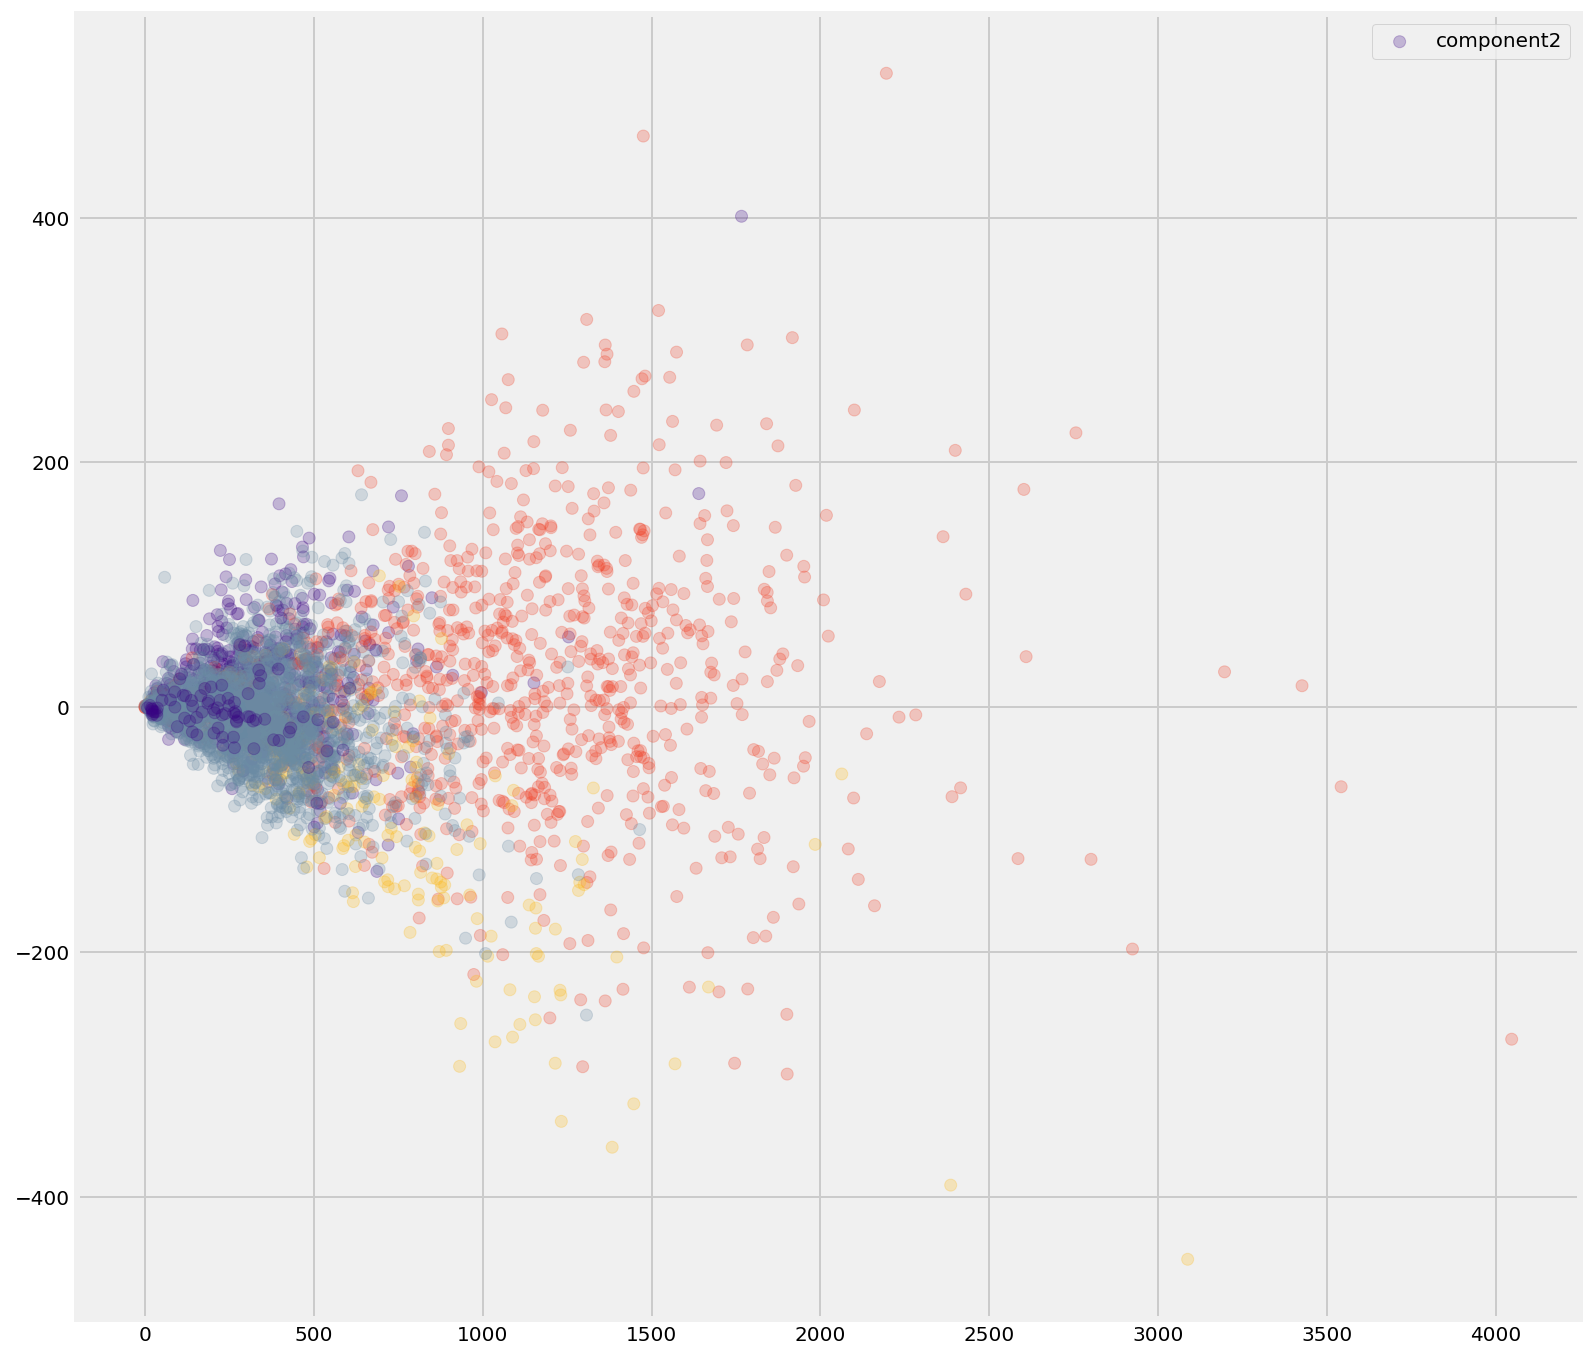

In [180]:
plt.figure(figsize=(12, 12))
plt.scatter(albums_df['component1'], albums_df['component2'], c=albums_df['primary_color'].values, alpha=0.25)
plt.legend()

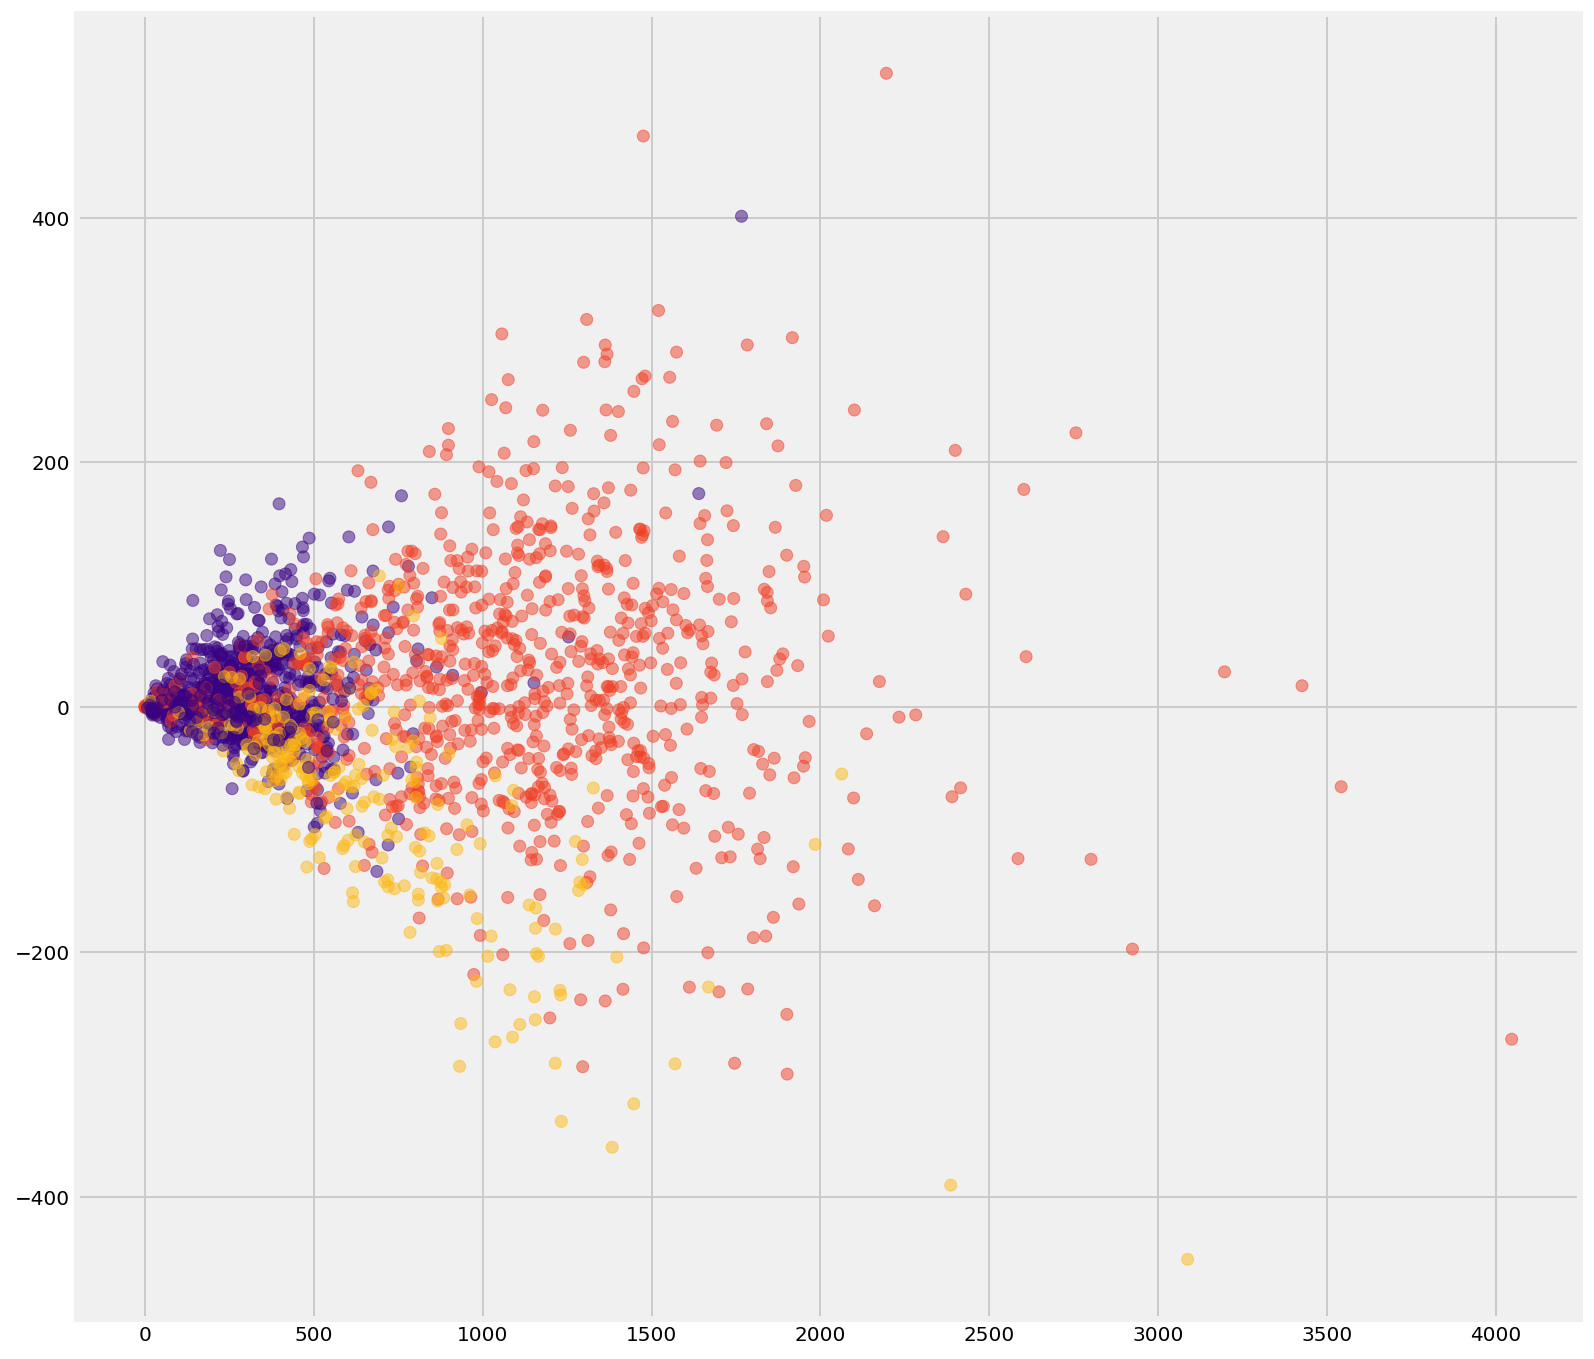

In [181]:
df = albums_df.loc[~(albums_df['primary_genre'] == 'rock')]

plt.figure(figsize=(12, 12))
plt.scatter(df['component1'], df['component2'], c=df['primary_color'].values, alpha=0.5)

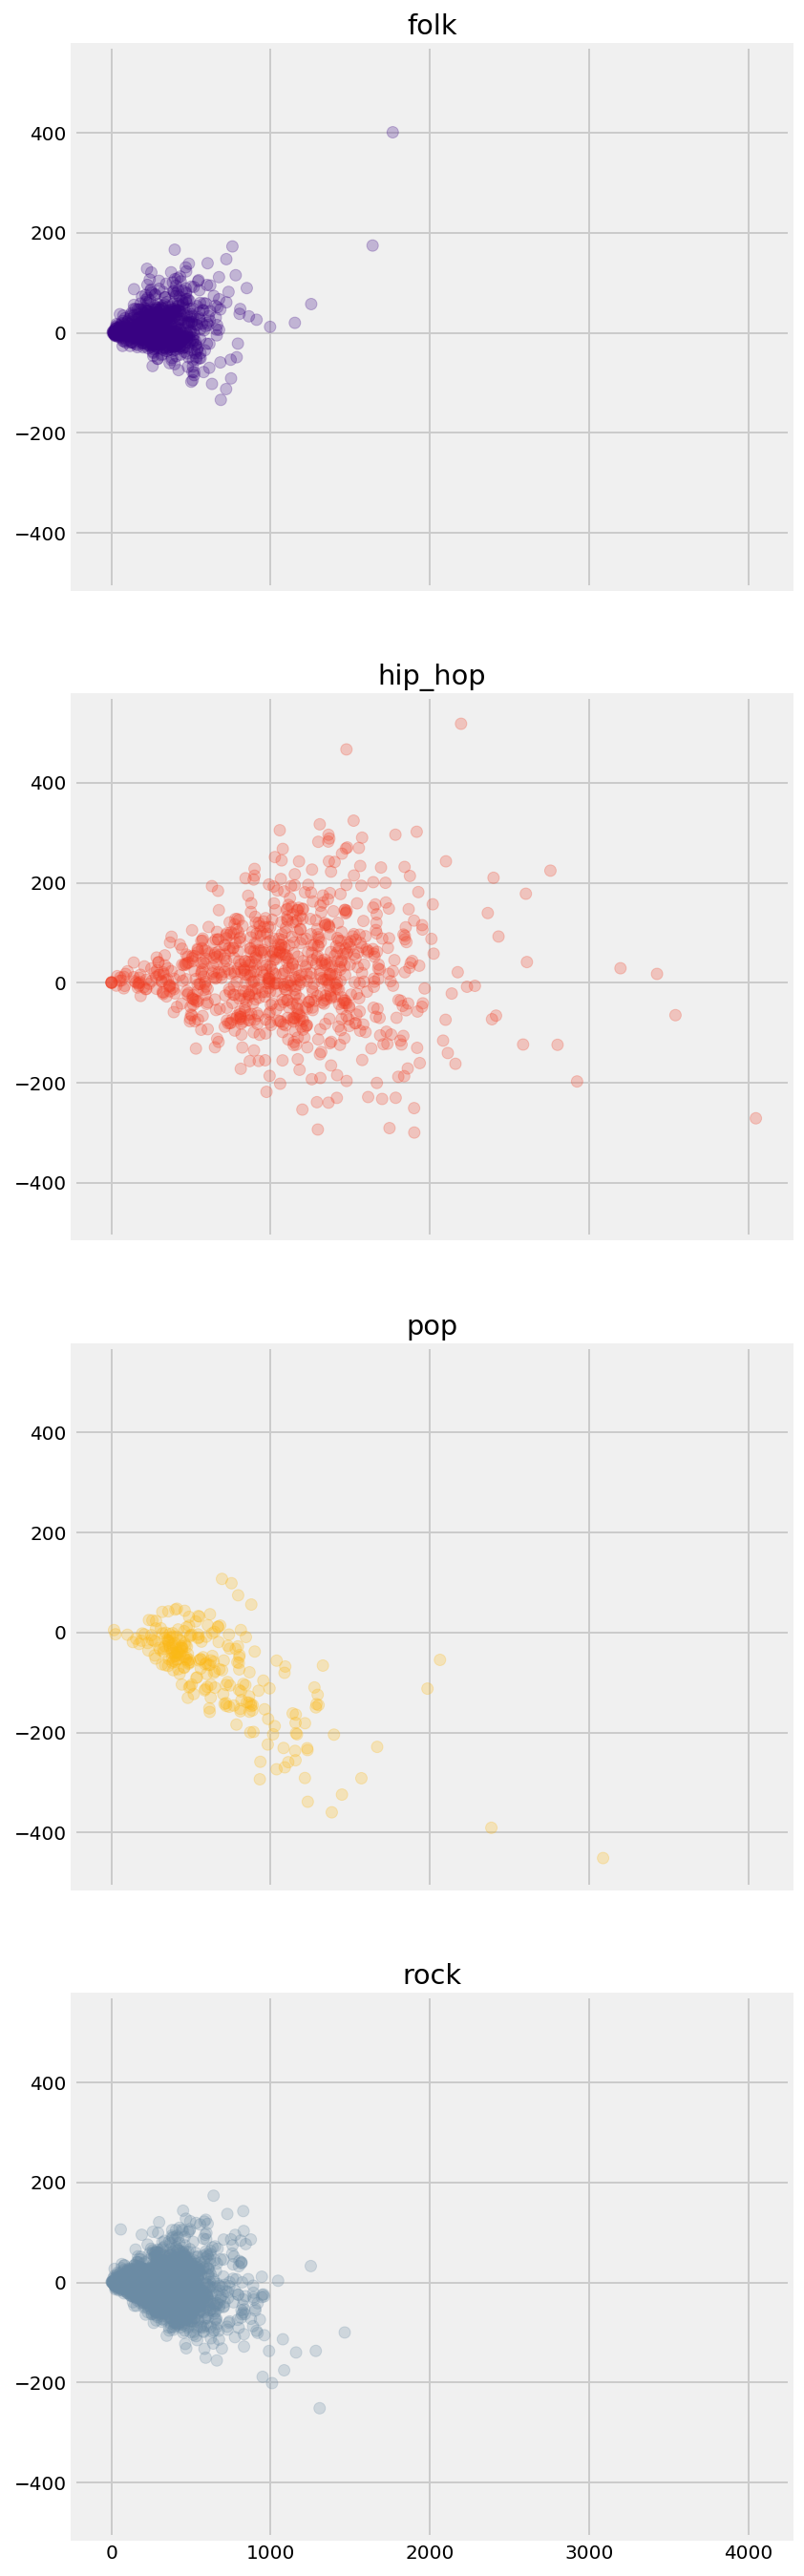

In [178]:
fig, ax = plt.subplots(4, 1, figsize=(6, 24), sharex=True, sharey=True)
for count, genre in enumerate(albums_df['primary_genre'].unique()):
    df = albums_df.loc[albums_df['primary_genre'] == genre]
    ax[count].scatter(df['component1'], df['component2'], c=df['primary_color'].values, alpha=0.25)
    ax[count].set_title(genre)

In [175]:
albums_df['distance_from_zero'] = np.sqrt((albums_df['component1'] ** 2) + (albums_df['component2'] ** 2))

In [177]:
albums_df.loc[albums_df['primary_genre'] == 'folk'].sort_values(by='distance_from_zero', ascending=False)

,album_id,lyrics,is_folk,is_folk_rock,is_indie_folk,is_alt_country,is_alt_rock,is_experimental_rock,is_hip_hop,is_pop_songs,is_rock_songs,tokens,primary_genre,primary_color,component1,component2,distance_from_zero
411,574,"There you were, a little kid in the yard n I w...",1,0,0,0,0,0,0,0,0,there you were a little kid in the yard eol i ...,folk,xkcd:indigo,1766.486703,401.134178,1811.459053
51,66,[Verse 1] n Every step of the way we walk the ...,1,0,0,0,0,0,0,0,0,verse1 eol every step of the way we walk the l...,folk,xkcd:indigo,1639.984351,174.564694,1649.248769
17,20,Easy n Easy n My man and me n We could rest an...,1,0,1,0,0,0,0,0,0,easy eol easy eol my man and me eol we could r...,folk,xkcd:indigo,1254.394780,57.444991,1255.709438
21,25,Come gather 'round people n Wherever you roam ...,1,0,0,0,0,0,0,0,0,come gather round people eol wherever you roam...,folk,xkcd:indigo,1151.882035,19.904295,1152.053994
50,65,Here is the sound that photographs make n When...,1,0,1,0,0,0,0,0,0,here is the sound that photographs make eol wh...,folk,xkcd:indigo,996.272931,11.899883,996.343997
46,59,[Verse] n He thought he was the King of Americ...,1,1,0,0,0,0,0,0,0,verse eol he thought he was the king of americ...,folk,xkcd:indigo,911.362051,26.145787,911.737018
226,303,[Intro Skit: Blake Sennett & Jenny Lewis] n Se...,1,0,0,0,0,0,0,0,0,intro skit blake sennett jenny lewis eol seem...,folk,xkcd:indigo,863.353823,32.916833,863.981100
381,531,[Verse 1] n Listen to that Duquesne whistle bl...,1,1,0,0,0,0,0,0,0,verse1 eol listen to that duquesne whistle blo...,folk,xkcd:indigo,849.849540,89.452916,854.544361
382,532,It was backstage in Moscow late one night n We...,1,0,0,0,0,0,0,0,0,it was backstage in moscow late one night eol ...,folk,xkcd:indigo,808.774147,47.631920,810.175549
433,603,"These roads, they lead as far as they can lead...",1,0,1,0,0,0,0,0,0,these roads they lead as far as they can lead ...,folk,xkcd:indigo,804.496354,37.949003,805.390905


In [246]:
cv_1 = CountVectorizer(ngram_range=(1, 1), stop_words=['chourus, verse, eos, eol, n', '1', '2', '3', '4'])

tokens_v_1 = cv_1.fit_transform(tokens)

array_tokens_1 = tokens_v_1.toarray()

In [249]:
unique_words = np.sum(array_tokens_1, axis=1)

In [284]:
unique_words.shape

(3804,)

In [250]:
albums_df['unique_words'] = unique_words

In [251]:
albums_df

,album_id,lyrics,is_folk,is_folk_rock,is_indie_folk,is_alt_country,is_alt_rock,is_experimental_rock,is_hip_hop,is_pop_songs,is_rock_songs,tokens,primary_genre,primary_color,component1,component2,distance_from_zero,score,unique_words
0,0,[hook] n I've been to a minor place n And I ca...,1,0,1,0,0,0,0,0,0,hook eol ive been to a minor place eol and i c...,folk,xkcd:indigo,391.502696,-28.241456,392.519989,100,2224
1,1,"[Verse 1] n When you were young, you were the ...",1,0,1,0,0,0,0,0,0,verse1 eol when you were young you were the ki...,folk,xkcd:indigo,372.068010,14.026588,372.332310,100,2499
2,2,Downtown n My darling dime store thief n In th...,1,0,0,0,0,0,0,0,0,downtown eol my darling dime store thief eol i...,folk,xkcd:indigo,424.510097,55.921874,428.177621,100,2531
3,3,[Verse 1] n Early one morning the sun was shin...,1,1,0,0,0,0,0,0,0,verse1 eol early one morning the sun was shini...,folk,xkcd:indigo,642.711832,73.747710,646.929060,100,4322
4,4,[Verse 1] n Love came to my door n With a slee...,1,1,0,0,0,0,0,0,0,verse1 eol love came to my door eol with a sle...,folk,xkcd:indigo,490.005598,-19.072339,490.376631,100,2780
5,5,[Verse] n I saw it written and I saw it say n ...,1,0,0,0,0,0,0,0,0,verse eol i saw it written and i saw it say eo...,folk,xkcd:indigo,194.295902,4.163730,194.340510,100,968
6,6,[Chorus] n I am on a lonely road and I am trav...,1,1,0,0,0,0,0,0,0,chorus eol i am on a lonely road and i am trav...,folk,xkcd:indigo,477.970259,-19.505483,478.368092,100,2861
7,7,Sailing hardships through broken harbors n Out...,1,1,0,0,0,0,0,0,0,sailing hardships through broken harbors eol o...,folk,xkcd:indigo,269.437784,-7.562668,269.543900,100,1413
8,8,[Verse 1] n What will happen in the morning n ...,1,1,0,0,0,0,0,0,0,verse1 eol what will happen in the morning eol...,folk,xkcd:indigo,287.098066,-0.570480,287.098633,97,1690
9,9,I dreamt I was an astronaut n Safely orbiting ...,1,0,0,0,0,0,0,0,0,i dreamt i was an astronaut eol safely orbitin...,folk,xkcd:indigo,24.944721,3.110093,25.137856,96,135


In [277]:
def tokenizer(string):
    for word in ['chourus', 'hook', 'verse', 'eos', 'eol', ' n ', '1', '2', '3', '4']:
        string = string.replace(word, '')
    string = string.replace('  ', ' ')
    string = string.strip()
    return string

In [254]:
len(tokenizer(albums_df['tokens'][0]).split())

2353

In [268]:
tokes = albums_df['tokens']

In [286]:
list_of_total_word_counts = []
for toke in tokes:
    num_words = len(tokenizer(toke).split())
    list_of_total_word_counts.append(num_words)

In [288]:
albums_df['total_words'] = list_of_total_word_counts

In [310]:
array_tokens_1.shape[0]

3804

In [311]:
unique_word_counts = []
for album in range(array_tokens_1.shape[0]):
    vect_album = array_tokens_1[album]
    indexes = []
    for count, num in enumerate(vect_album):
        if num != 0:
            indexes.append(count)
    unique_word_counts.append(len(indexes))

In [314]:
albums_df['unique_words'] = unique_word_counts

In [316]:
albums_df['unique_percent'] =  albums_df['unique_words'] / albums_df['total_words']

In [324]:
cv_2 = CountVectorizer(ngram_range=(3, 4), stop_words=stop)

tokens_v_2 = cv_2.fit_transform(tokens)

array_tokens_2 = tokens_v_2.toarray()

In [325]:
svd_2 = TruncatedSVD(n_components=2, random_state=2018)

svd_array_tokens_2 = svd_2.fit_transform(array_tokens)

albums_df['component21'] = svd_array_tokens_2[:, 0]

albums_df['component22'] = svd_array_tokens_2[:, 1]

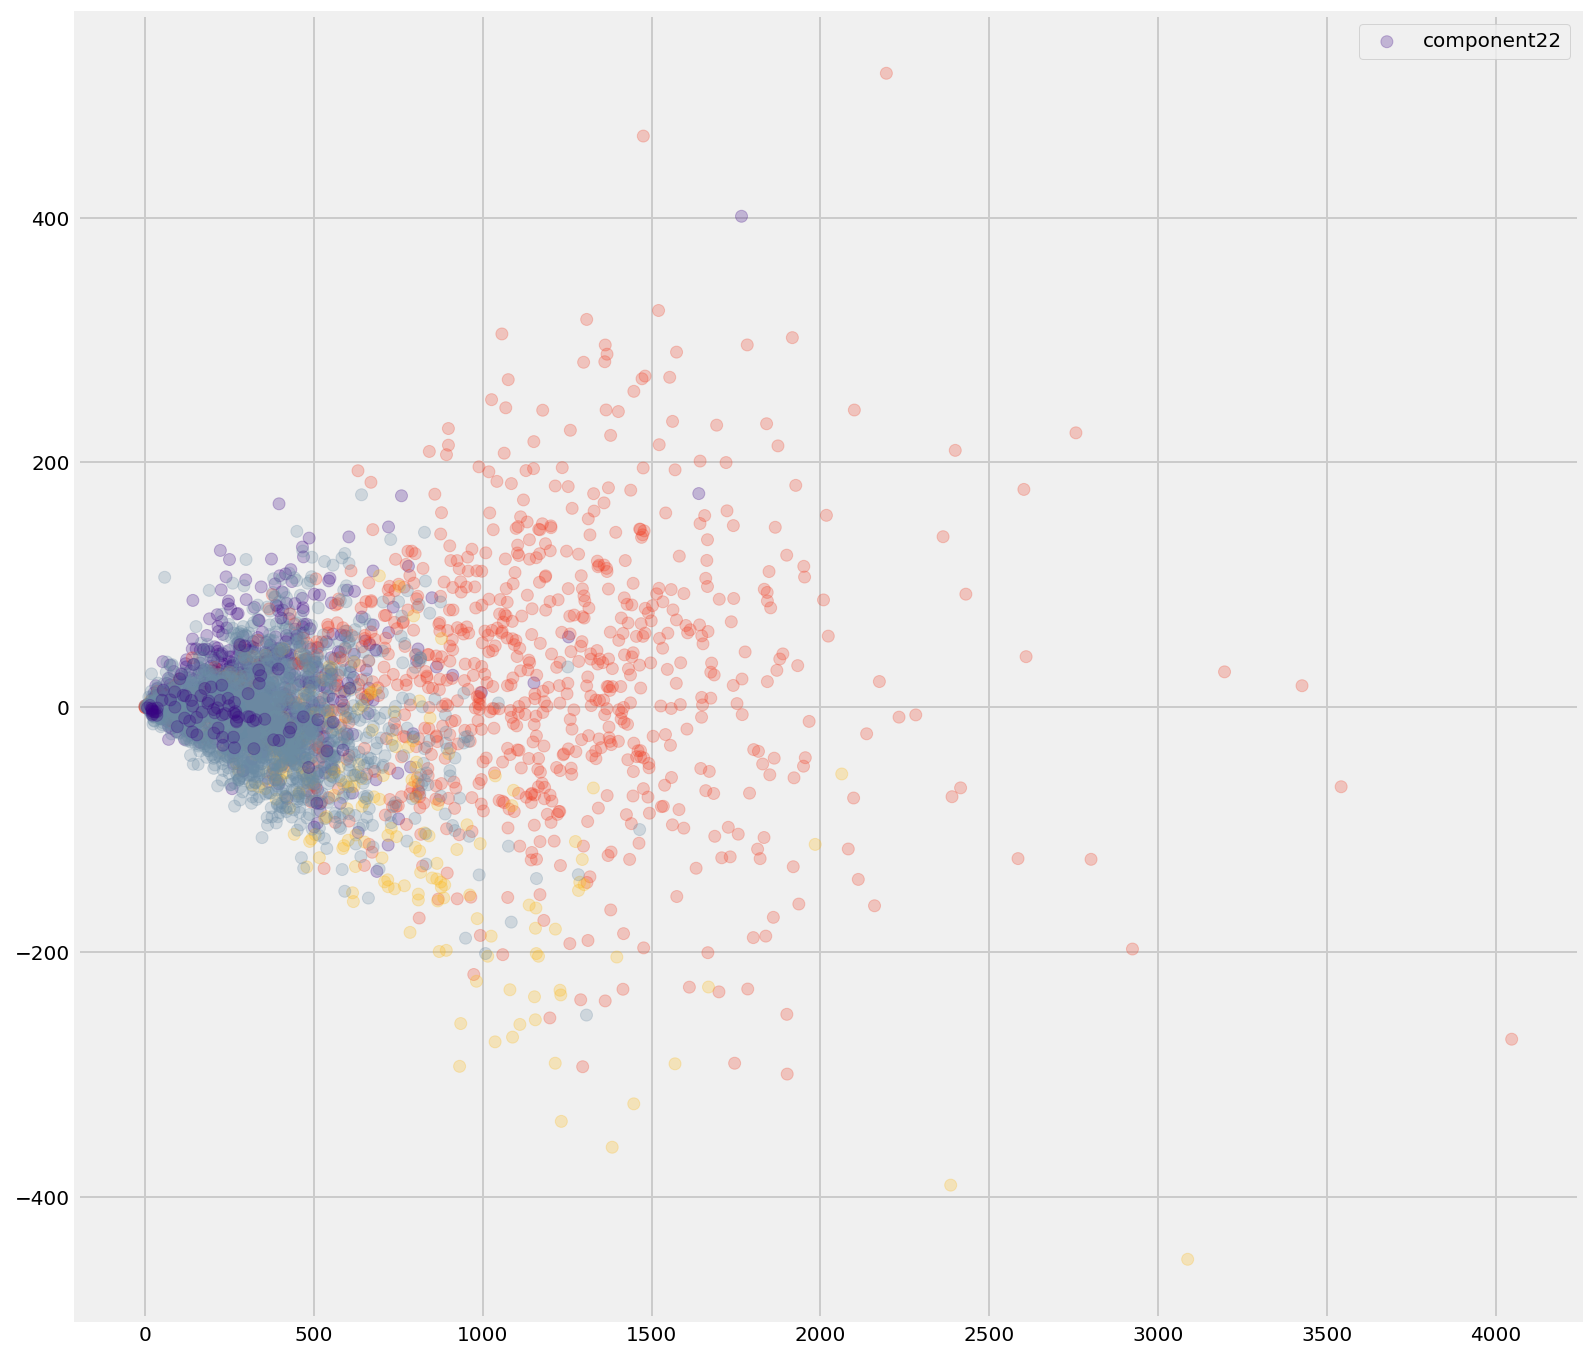

In [326]:
plt.figure(figsize=(12, 12))
plt.scatter(albums_df['component21'], albums_df['component22'], c=albums_df['primary_color'].values, alpha=0.25)
plt.legend()

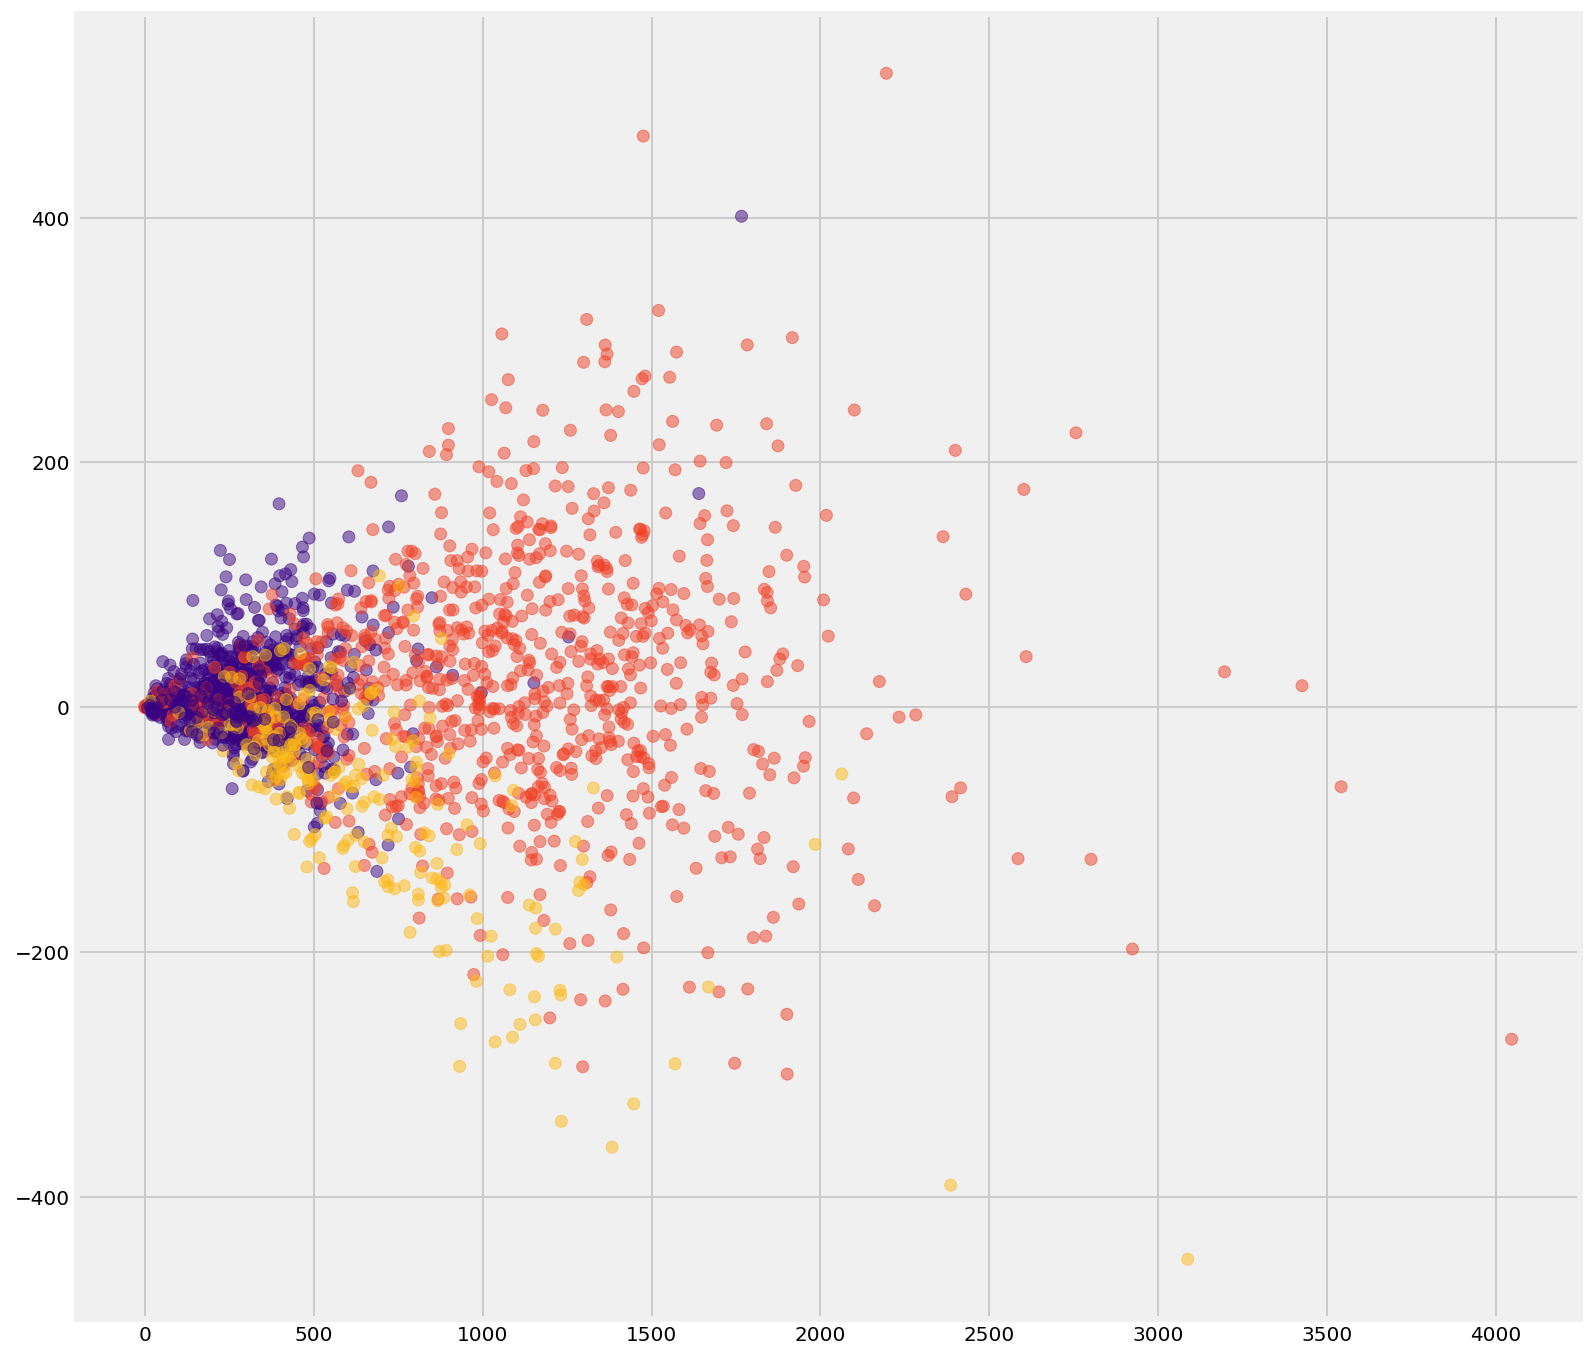

In [329]:
df = albums_df.loc[~(albums_df['primary_genre'] == 'rock')]

plt.figure(figsize=(12, 12))
plt.scatter(df['component21'], df['component22'], c=df['primary_color'].values, alpha=0.5)

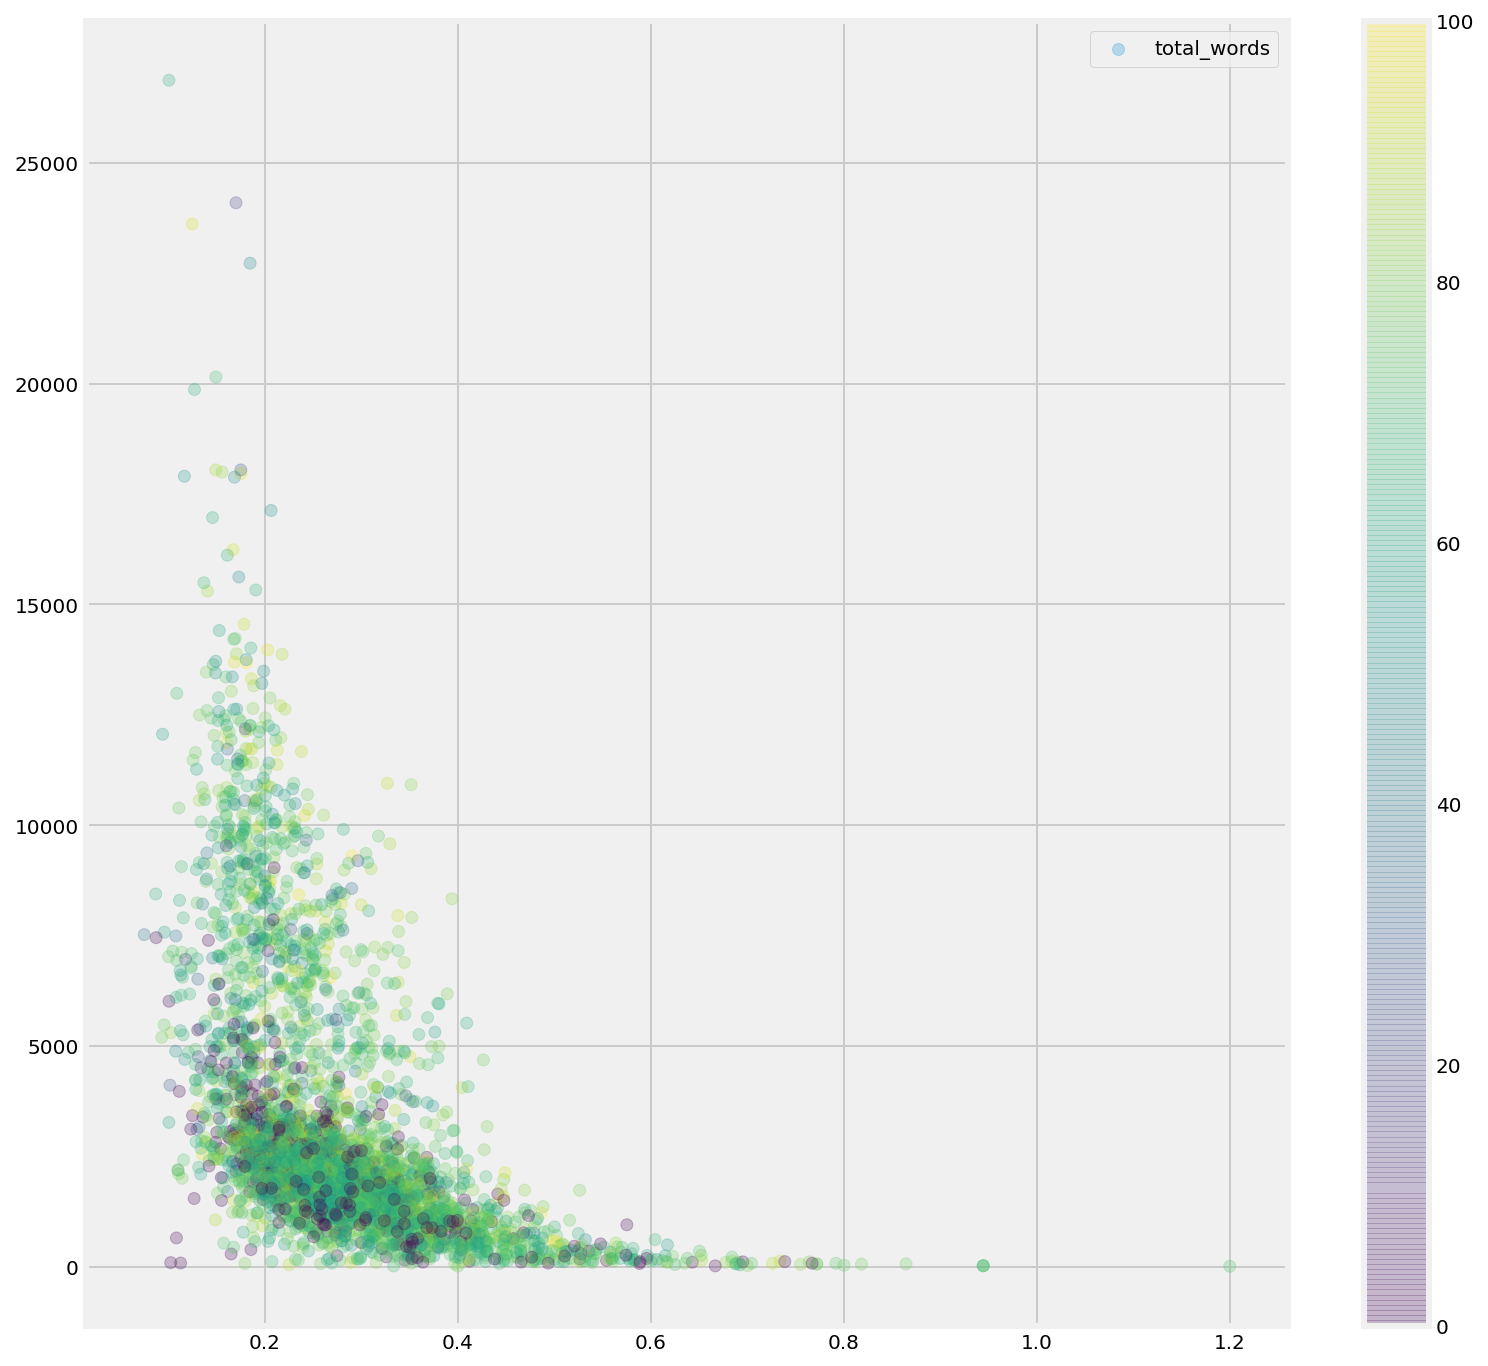

In [323]:
plt.figure(figsize=(12, 12))
plt.scatter(albums_df['unique_percent'], albums_df['total_words'], c=albums_df['score'].values, alpha=0.25)
plt.colorbar()
plt.legend()

In [61]:
all_songs = []
for song in tokens:
    for token in song:
        all_songs.append(token)

In [62]:
len(all_songs)

15908654

In [63]:
counter = collections.Counter(all_songs)

In [68]:
counter.most_common(10000)

[('eol', 2076733),
 ('the', 563912),
 ('i', 444203),
 ('you', 388982),
 ('and', 301515),
 ('a', 288684),
 ('to', 280514),
 ('in', 189748),
 ('my', 187259),
 ('it', 179484),
 ('me', 176802),
 ('of', 137241),
 ('on', 135960),
 ('that', 124598),
 ('your', 119595),
 ('im', 118168),
 ('all', 97049),
 ('like', 92922),
 ('is', 92252),
 ('for', 92034),
 ('we', 90184),
 ('with', 86036),
 ('up', 80343),
 ('be', 77357),
 ('but', 76330),
 ('dont', 75502),
 ('know', 74034),
 ('so', 71655),
 ('its', 71031),
 ('this', 66853),
 ('no', 65540),
 ('got', 63702),
 ('just', 62715),
 ('get', 59962),
 ('what', 59200),
 ('when', 58175),
 ('out', 57885),
 ('they', 57740),
 ('love', 50879),
 ('now', 50509),
 ('do', 49349),
 ('was', 49115),
 ('oh', 48530),
 ('if', 45925),
 ('can', 45129),
 ('go', 43702),
 ('down', 43553),
 ('yeah', 41058),
 ('she', 40686),
 ('from', 40267),
 ('not', 40193),
 ('at', 39577),
 ('chorus', 39569),
 ('see', 39385),
 ('one', 38407),
 ('time', 37481),
 ('never', 37164),
 ('are', 36595),

In [189]:
folk_dict = pickle.load(open('/Users/adam/all_folk_albums.pkl', 'rb'))

In [187]:
hip_hop_dict = pickle.load(open('/Users/adam/hip_hip_album_dict.pkl', 'rb'))

In [188]:
pop_dict = pickle.load(open('/Users/adam/pop_album_dict.pkl', 'rb'))

In [190]:
rock_dict = pickle.load(open('/Users/adam/Rock_album_dict.pkl', 'rb'))

In [191]:
alt_country_dict = pickle.load(open('/Users/adam/alt_country_album_dict.pkl', 'rb'))

In [197]:
combined_dictionary = folk_dict.copy()
combined_dictionary.update(hip_hop_dict)
combined_dictionary.update(pop_dict)
combined_dictionary.update(rock_dict)
combined_dictionary.update(alt_country_dict)

In [201]:
combined_dictionary[0]

{'album': 'I See a Darkness',
 'album_id': 0,
 'artist': "Bonnie 'Prince' Billy",
 'is_folk': 1.0,
 'is_folk_rock': 0.0,
 'is_indie_folk': 1.0,
 'release_date': 'January 19, 1999',
 'score': '100'}

In [212]:
def get_score(row):
    try:
        album_id = row['album_id']
        score = combined_dictionary[album_id]['score']
        return int(score)
    except:
        return 0

In [213]:
albums_df['score'] = albums_df.apply(get_score, axis=1)

In [216]:
above_80 = albums_df.loc[albums_df['score'] >= 80]

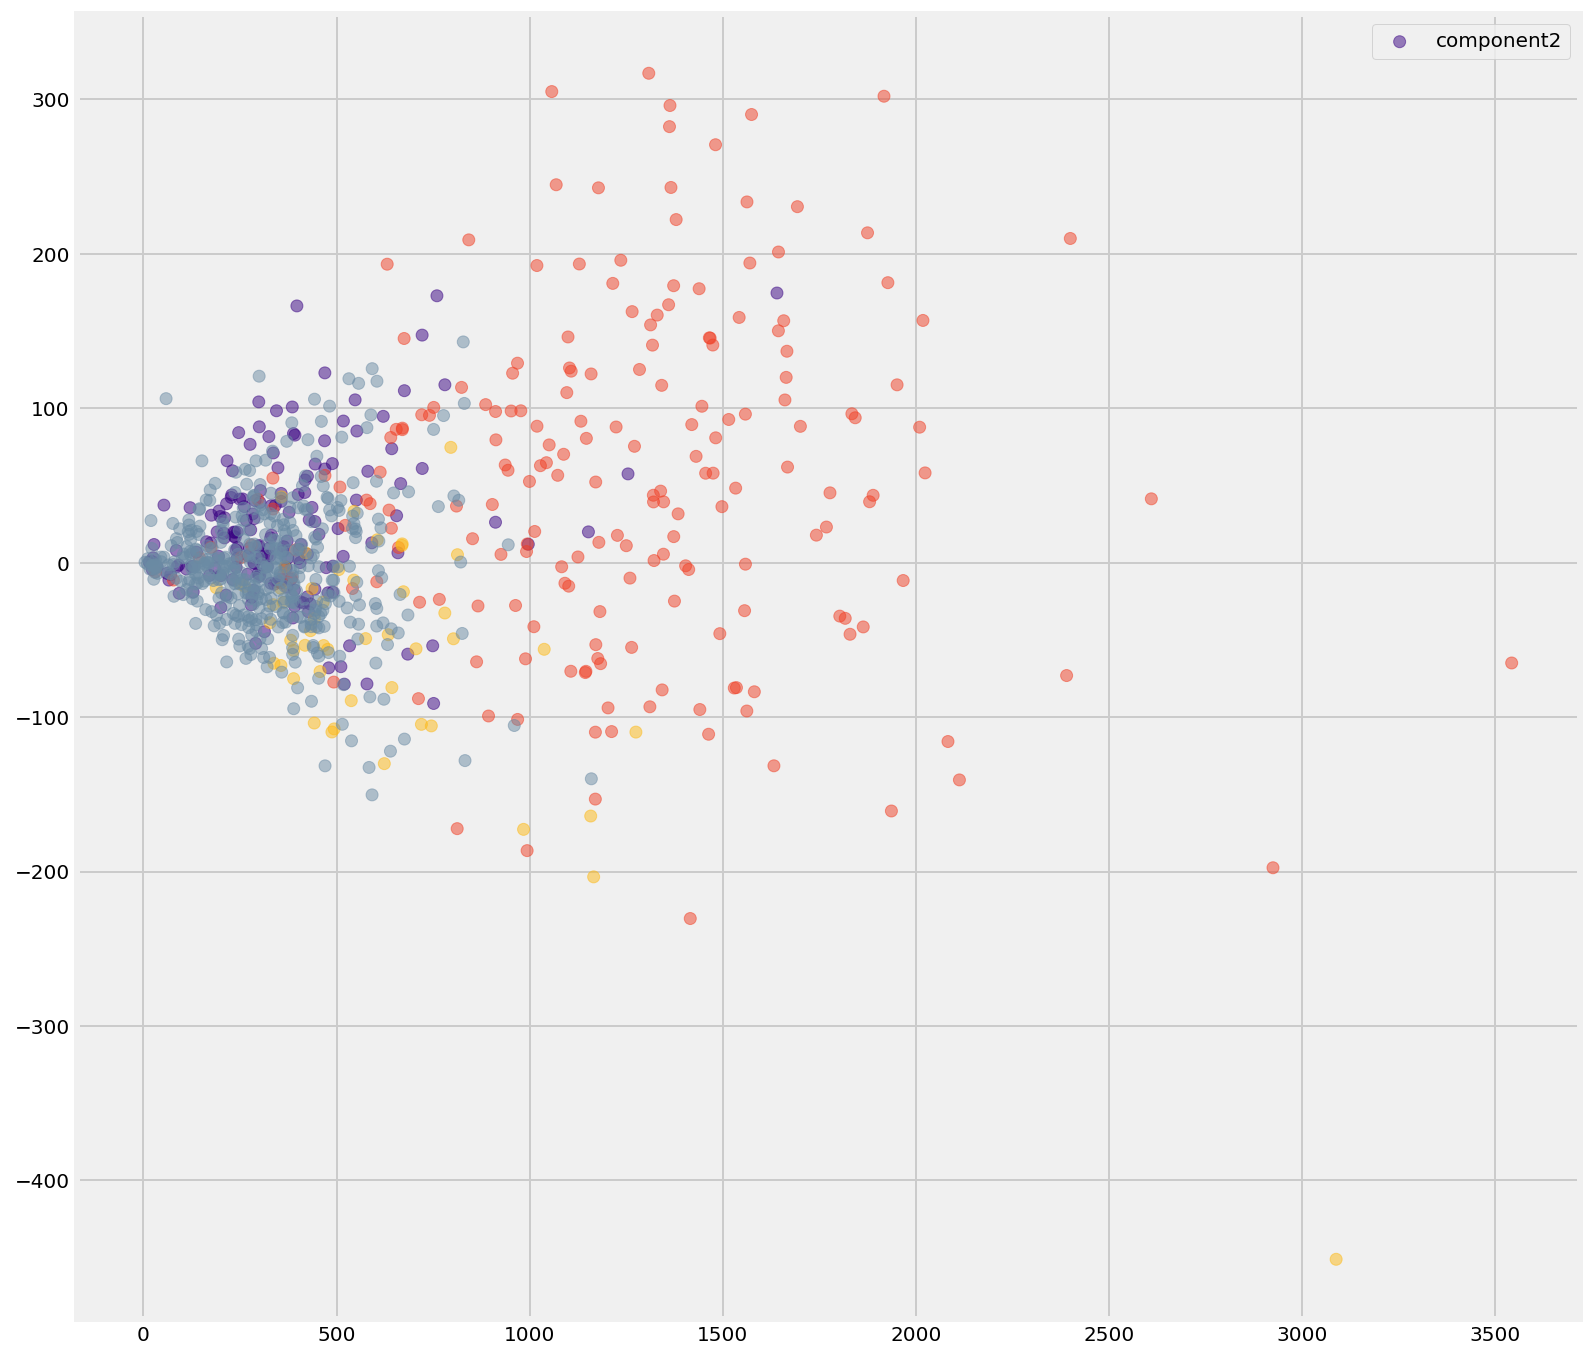

In [218]:
plt.figure(figsize=(12, 12))
plt.scatter(above_80['component1'], above_80['component2'], c=above_80['primary_color'].values, alpha=0.5)
plt.legend()

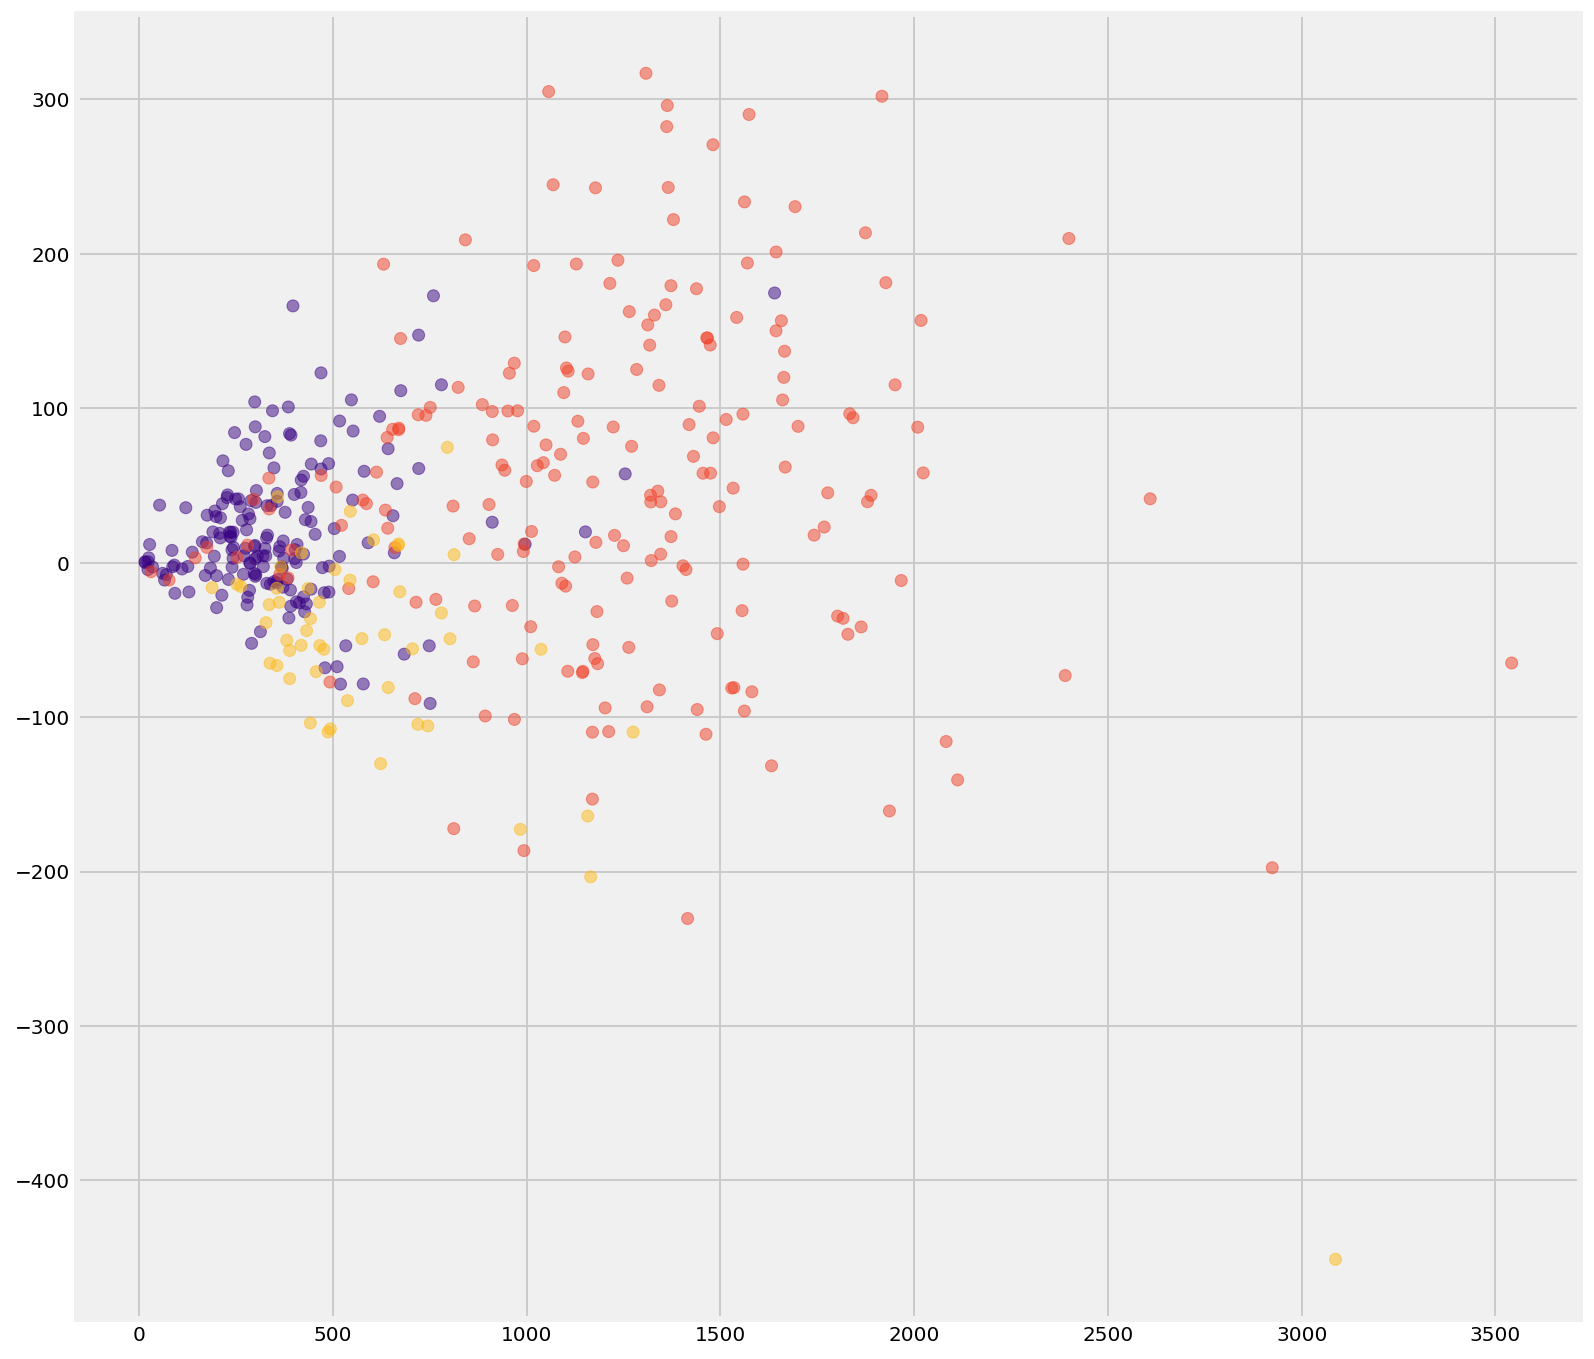

In [219]:
df = above_80.loc[~(above_80['primary_genre'] == 'rock')]

plt.figure(figsize=(12, 12))
plt.scatter(df['component1'], df['component2'], c=df['primary_color'].values, alpha=0.5)